## Analysing Buyer Behaviour Using Transaction Logs

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

#### Import Transaction Logs Data

In [2]:
# Import transaction log, identify & set header, omit customer source data, set order_date as datetime dtype
df = pd.read_csv("data/transaction-log-example.csv", 
                 header=0, 
                 delimiter=",", 
                 usecols=['cust_id','order_date', 'net_sales', 'source'], 
                 parse_dates=['order_date'],
                 dtype={'cust_id': 'str',
                        'net_sales': 'float64',
                        'source': 'category'},
                 index_col=['order_date'])
df.head()

,cust_id,net_sales,source
order_date,,,
2018-02-16,cust16647,108.784,web
2018-03-28,cust17852,117.000,web
2018-09-27,cust17852,315.900,web
2019-03-08,cust17852,159.250,web
2016-05-18,cust588,298.350,web


In [3]:
df_mkt = pd.read_csv("data/mktg-spend-example.csv", 
                 header=0, 
                 delimiter=",", 
                 usecols=['month','total_marketing_spend'], 
                 parse_dates=['month'],
                 dtype={'total_marketing_spend': 'float64'},               
                 index_col=['month'])

df_mkt.head()

,total_marketing_spend
month,
2016-01-01,648.653944
2016-02-01,988.526343
2016-03-01,928.085792
2016-04-01,685.889176
2016-05-01,1724.866225


### Context

- **Customer centricity**: need to measure and manage customer value
- CLV is important, but it requires a **statistical model** 
- Valuable to have **auditable performance measures**
- We can use raw transaction log that consists of customer ID, transaction date, and net sales to compute and evaluate KPIs.
- In addition to the transaction log, we need to use marketing spend data and contribution margin to compute initial purchase profit and contribution profit performance (Margin data: spend -> variable profit).
- We will use a real transaction log:
  - Real high-growth “bricks and clicks” startup
  - $’s scaled, dates shifted
- Need to understand variation in sales and profit across: 
  - Purchases
  - Customers
  - Sources/channels
  - Calendar Time
  - Tenure

#### Key Performance Indicators (KPIs)

Calculate “from scratch”: 
1. Monthly sales over time
2. Total customers acquired 
3. Customer acquisition cost (CAC)
4. Distribution of spend per purchase
5. Initial versus repeat sales volume
6. Initial versus repeat average order value (AOV)
7. Sales and AOV by source
8. First-purchase profitability
9. Cohorted sales (the “C3”)
10. Revenue retention curves
11. Cumulative spend per customer
12. Distribution of total spend by customer
13. Customer concentration (“Pareto”) chart 

What they summarize: 
1. Growth
2. Unit costs
3. Unit profitability (unit economic performance)
4. Retention
5. Heterogeneity (customers, time)

### Analysis

#### 1. Total monthly sales

- **What**: total sales across all customers each month
- **Why**: most standard, commonly-used growth metric to demonstrate past performance and expected future performance
- **How**: group and aggregate (sum) net sales by year and month

**Analysis**: Data shows seasonality with relatively higher sales from October through December as compared to the rest of the year. Data also shows sales are rising year-on-year. Time series decomposition analysis below demonstrates the rising trend and seasonality in the data.

In [4]:
sales = df.groupby([(df.index.year), (df.index.month)])['net_sales'].sum()
sales.unstack()

order_date,1,2,3,4,5,6,7,8,9,10,11,12
order_date,,,,,,,,,,,,
2016,21395.010,31661.305,38094.407,24398.595,36170.030,83308.498,81053.024,111414.979,119505.412,161253.287,223141.646,243675.627
2017,124408.180,132210.728,195413.972,202013.188,237466.827,241425.470,222988.766,234852.293,284023.233,411017.581,548646.332,757308.032
2018,307756.319,316357.886,376486.838,429182.598,555779.198,542620.845,563051.736,614858.790,693434.443,738637.185,733041.049,1013547.405
2019,510834.298,560820.260,691195.674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(0.0, 1300000.0)

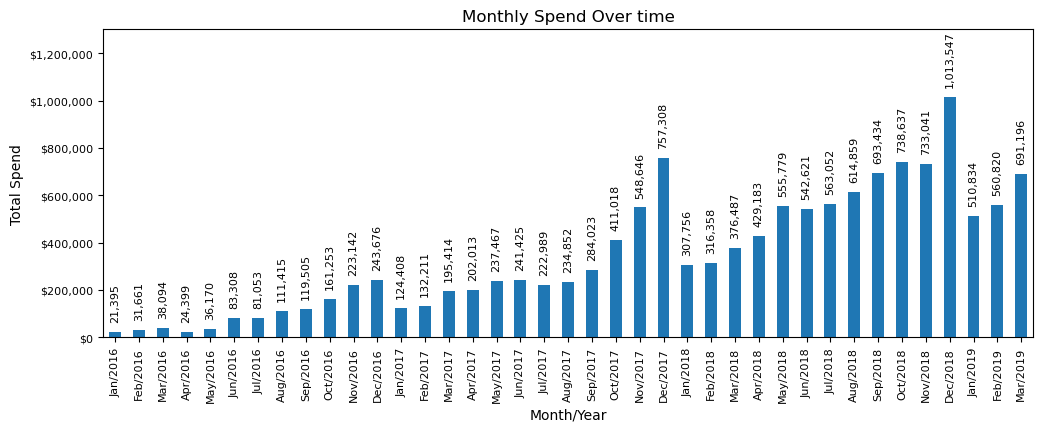

In [5]:
from matplotlib.ticker import FuncFormatter

ax = sales.plot(kind='bar',  
            figsize=(12,4),
            title="Monthly Spend Over time",
            xlabel='Month/Year',
            ylabel='Total Spend',
            fontsize=8)

ax.set_xticklabels([f'{pd.Timestamp(year=y, month=m, day=1):%b/%Y}' for y, m in sales.index], 
                   rotation=90, 
                   ha='center')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${y:,.0f}'))

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+50000, f'{y[i]:,.0f}', ha='center', rotation ='vertical', snap=True, size=8)
        
addlabels(sales.index, sales.values)

ax.set_ylim(0, 1_300_000)

##### Time Series Decomposition

**Breaking Down the Components in Time Series Decomposition**:
When a time series is decomposed, it is often represented as:
$$\text{Observed Data} = \text{Trend} + \text{Seasonality} + \text{Remainder (Residual/Error)}$$
Each component has a role:
- **Trend Component**: Captures the long-term progression or direction in the data (upward, downward, or stable trend over time).
- **Seasonal Component**: Captures the repeating, cyclical patterns that occur at regular intervals (e.g., monthly or quarterly patterns).
- **Remainder Component**: Captures the random noise, unexpected variations, and irregular fluctuations that are not explained by trend or seasonality.

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(sales, model='additive', period=12)

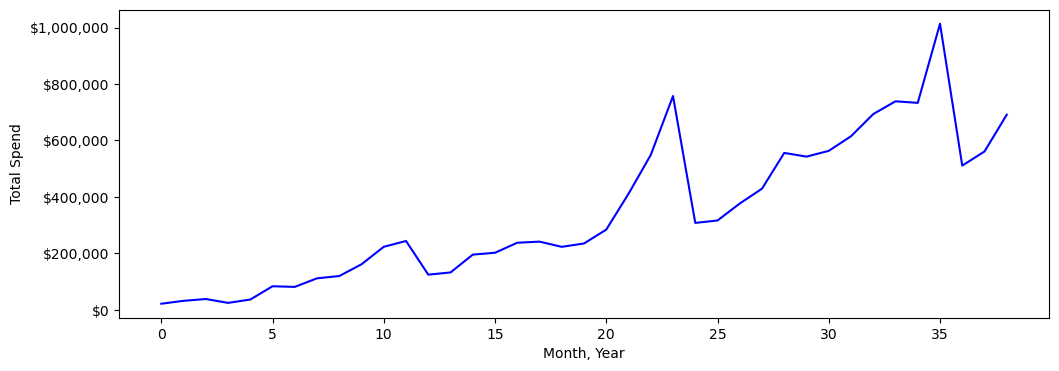

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
ax.plot(sales.values, color='b')
ax.set_xlabel('Month, Year')
ax.set_ylabel('Total Spend')
ax.yaxis.set_major_formatter(FuncFormatter(FuncFormatter(lambda y, _: f'${y:,.0f}')))
plt.show()

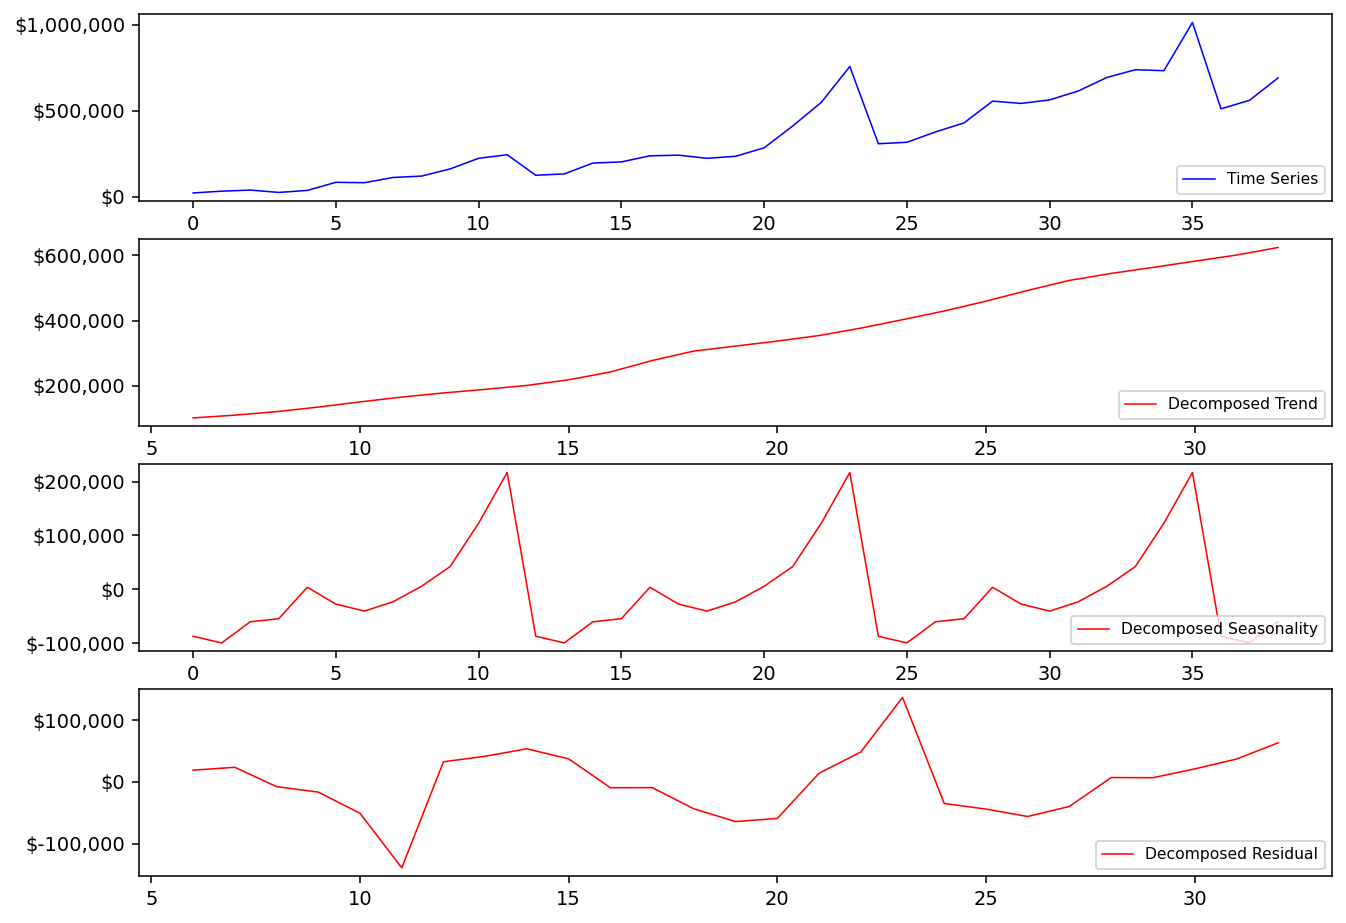

In [8]:
def effects(ax, values, color, label):
    ax.plot(values, color=color, lw=0.8, ms=0, label=label)
    ax.yaxis.set_major_formatter(FuncFormatter(FuncFormatter(lambda y, _: f'${y:,.0f}')))
    ax.legend(loc='lower right', fontsize=8)
    return

fig, axes = plt.subplots(4, 1, figsize=(11,8), dpi=140)
effects(axes[0], sales.values, 'b', 'Time Series')
effects(axes[1], result.trend.values, 'r', 'Decomposed Trend')
effects(axes[2], result.seasonal.values, 'r', 'Decomposed Seasonality')
effects(axes[3], result.resid.values, 'r', 'Decomposed Residual')
plt.show()

**Seasonal Strength**:
   - **F-statistic**: Measures how strong the seasonal component is relative to the residual (error) component. It’s a statistical test from ANOVA that compares the variance in the seasonal component to the variance in the remainder component.
     - When using an F-statistic to evaluate the strength of the seasonal component, the remainder component serves as a baseline for comparison. The F-statistic measures how much of the variation in the data can be attributed to seasonality versus what is left unexplained (the remainder). If the seasonal component explains a large proportion of the variation (relative to the remainder), it indicates a strong, consistent seasonal effect.
   - **Coefficient of Determination (R²)**: Indicates the proportion of variance in the original time series data explained by the seasonal component. A high $R^2$ value suggests a strong and consistent seasonal pattern.

In [9]:
from scipy.stats import f_oneway, linregress
stat, pvalue = f_oneway(result.seasonal, result.resid, nan_policy='omit')
print(f'F-statistics: \n {stat = :0.4f}\n {pvalue = :0.4f}')

coeff_det = linregress(result.seasonal, sales).rvalue
print(f'Coefficient of Determination: \n {coeff_det = :0.4f}')

F-statistics: 
 stat = 0.0755
 pvalue = 0.7844
Coefficient of Determination: 
 coeff_det = 0.4570


**Seasonal Variation Measure**:
- **Seasonal Amplitude**: Calculated as the difference between the maximum and minimum values of the seasonal component, it shows the full range of seasonal fluctuations within a cycle.
- **Standard Deviation of Seasonal Component**: This measures the variability within the seasonal component itself. It’s particularly useful if you want to quantify the spread or dispersion in the seasonal component.

In [10]:
seasonal_amp = np.max(result.seasonal) - np.min(result.seasonal)
print(f'Seasonal Amplitude = {seasonal_amp:,.0f}')
seasonal_std = np.std(result.seasonal)
print(f'St. Dev. Seasonal Component = {seasonal_std:,.0f}')

Seasonal Amplitude = 316,348
St. Dev. Seasonal Component = 86,575


In [11]:
# Free-up memory - Garbage collect
del result, sales, seasonal_amp, seasonal_std, coeff_det, stat, pvalue, fig, axes, ax
gc.collect()

24336

#### 2. Monthly Customer Acquisitions

- **What**: total first-time buyers each month
- **Why**: explains how growth is coming about (new users? existing users? …)
- **How**: sort by customer and transaction date, identify acquisition date for each customer (based on first purchase), and aggregate acquisitions by month

**Analysis**: First purchase of a unique customer ID is used here as a proxy for customer acquisition. Data shows that new customer acquisitions (or initial customer transactions) have trended upwards. Similar to the total monthly sales, the data shows seasonality; with acquisitions in November and December higher than the yearly average.

In [12]:
df = df.sort_values(by=['cust_id', 'order_date'])
df['initial_purch'] = (~df['cust_id'].duplicated()).astype(int)
acquired = df.groupby([(df.index.year), (df.index.month)])['initial_purch'].sum()
acquired.unstack()

order_date,1,2,3,4,5,6,7,8,9,10,11,12
order_date,,,,,,,,,,,,
2016,108.0,129.0,168.0,92.0,161.0,389.0,310.0,525.0,460.0,673.0,796.0,1086.0
2017,395.0,520.0,622.0,625.0,733.0,767.0,699.0,778.0,808.0,809.0,1449.0,2339.0
2018,786.0,819.0,903.0,1166.0,1588.0,1486.0,1499.0,1655.0,1661.0,1455.0,1758.0,2838.0
2019,1126.0,1103.0,1382.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


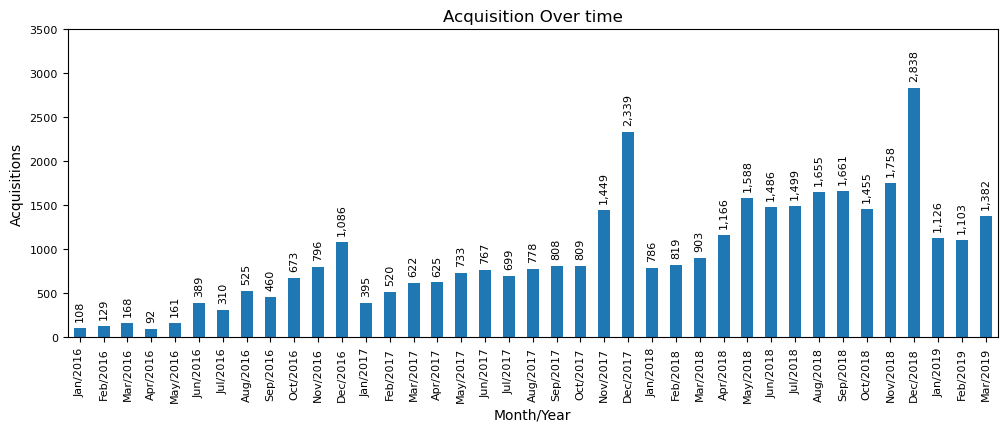

In [13]:
ax = acquired.plot(kind='bar',  
            figsize=(12,4),
            title="Acquisition Over time",
            xlabel='Month/Year',
            ylabel='Acquisitions',
            fontsize=8)

ax.set_xticklabels([f'{pd.Timestamp(year=y, month=m, day=1):%b/%Y}' for y, m in acquired.index], 
                   rotation=90, 
                   ha='center')

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+100, f'{y[i]:,.0f}', ha='center', rotation ='vertical', snap=True, size=8)
        
addlabels(acquired.index, acquired.values)

ax.set_ylim(0, 3500)

plt.show()

#### 3. Customer Acquisition Cost (CAC)

- **What**: amount spent per newly acquired customer over time
- **Why**: key driver of unit economics (remember, $E(CLV)=E(PAV)-CAC$)
- **How**: compute CAC by dividing market spend by customer acquisitions for each period

**Analysis**: Cost of acquiring new customers has increased over time. The average CAC in 2016 was $8.35 per customer, $19.72 in 2017, $36.23 in 2018, and $43.61 in 2019 (beginning of the year)

In [14]:
mktg_spend = df_mkt.groupby([(df_mkt.index.year), (df_mkt.index.month)])['total_marketing_spend'].sum()
cac = mktg_spend / acquired
cac.unstack()

month,1,2,3,4,5,6,7,8,9,10,11,12
month,,,,,,,,,,,,
2016,6.006055,7.662995,5.524320,7.455317,10.713455,7.342899,5.825060,6.969569,11.078503,11.868985,11.472615,8.332260
2017,10.097597,22.269116,12.645246,10.920224,29.646548,11.624200,12.745645,21.543598,17.848617,13.117770,34.319686,39.849331
2018,40.691258,21.341423,38.487964,41.052574,33.107560,48.839061,27.466391,37.088632,21.555379,52.222357,28.952526,43.926150
2019,29.666842,56.401616,44.772407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


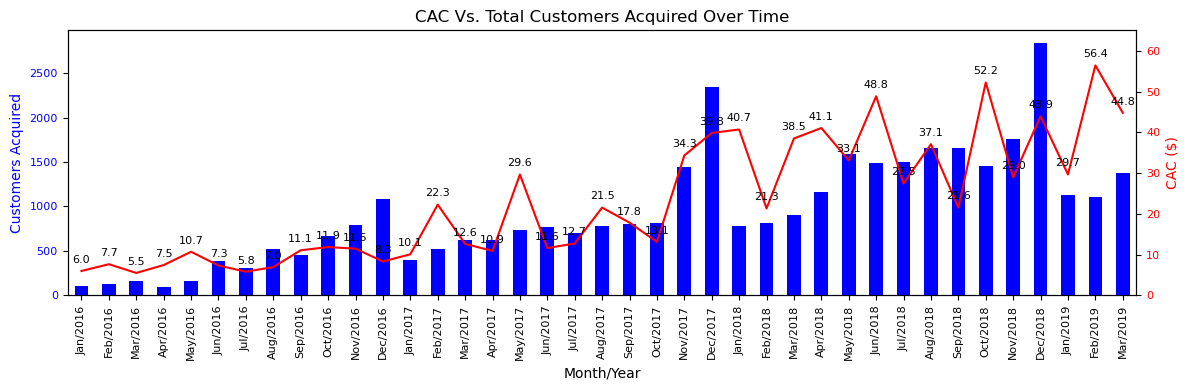

In [15]:
fig, ax1 = plt.subplots(figsize=(12,4))

ax1.set_ylabel('Customers Acquired', color='blue')  # we already handled the x-label with ax1
acquired.plot(ax=ax1, color='blue', kind='bar', fontsize=8, title="CAC Vs. Total Customers Acquired Over Time")
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

ax2.set_ylabel('CAC ($)', color='red')
cac.plot(ax=ax2, color='red', fontsize=8)
ax2.tick_params(axis='y', labelcolor='red')

def addlabels(x,y):
    for i in range(len(x)):
        ax2.text(i, y[i]+2, f'{y[i]:.1f}', ha='center', rotation ='horizontal', snap=True, size=8, color='black')
        
addlabels(cac.index, cac.values)

ax1.set_xticklabels([f'{pd.Timestamp(year=y, month=m, day=1):%b/%Y}' for y, m in acquired.index], 
                    rotation=90, 
                    ha='center')

ax1.set_xlabel('Month/Year')
ax2.set_ylim(0, 65)

fig.tight_layout() 
plt.show()

In [16]:
# Yearly average CAC
cac.groupby(level=0).mean()

month
2016     8.354336
2017    19.718965
2018    36.227606
2019    43.613622
dtype: float64

In [17]:
# Y-o-Y monthly average CAC
cac.groupby(level=1).mean()

month
1     21.615438
2     26.918787
3     25.357485
4     19.809372
5     24.489188
6     22.602054
7     15.345699
8     21.867266
9     16.827500
10    25.736371
11    24.914942
12    30.702580
dtype: float64

In [18]:
# Free-up memory - Garbage collect
del ax1, ax2, fig, mktg_spend
gc.collect()

15143

#### 4. Distribution of Spend per Purchase

- **What**: histogram of all spends in transaction log
- **Why**: better understand how heterogeneous customer spending is 

**Analysis**: histogram of the transaction data shows a highly skewed, long-tailed distribution of spend per transaction. About 80% of the transactions are below $292.77 with a median of $127.08, and an average spend of $189.19. 

In [19]:
from scipy.stats import describe
max_spend = df['net_sales'].max()
min_spend = df['net_sales'].min()
print(f'{max_spend = }')
print(f'{min_spend = }')

p80th = np.percentile(df['net_sales'], 80)
print(f'80th Percentile of Spends = ${p80th:0.2f}')

median = np.median(df['net_sales'])
print(f'Median = ${median:0.2f}')

print(describe(df['net_sales']))

max_spend = np.float64(19305.0)
min_spend = np.float64(-517.569)
80th Percentile of Spends = $292.77
Median = $127.08
DescribeResult(nobs=70904, minmax=(np.float64(-517.569), np.float64(19305.0)), mean=np.float64(189.1917373631953), variance=np.float64(41018.6299560282), skewness=np.float64(17.867584403877846), kurtosis=np.float64(1366.6957992074858))


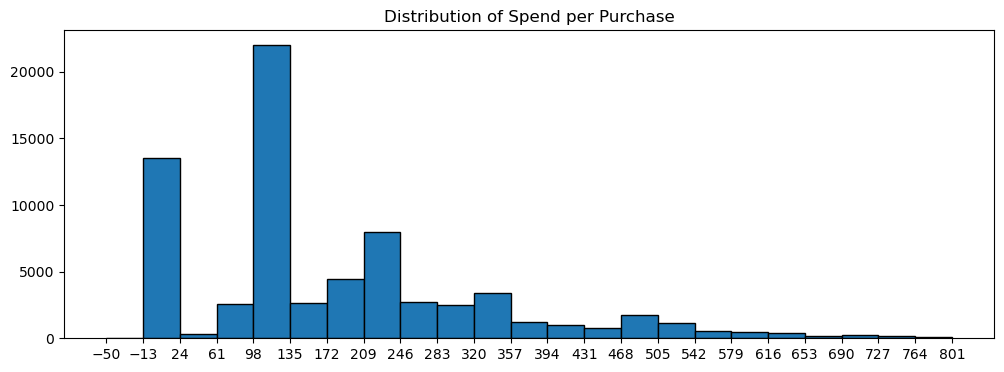

In [20]:
bins = list(range(-50, 820, 37))
plt.figure(figsize=(12,4))
plt.hist(df['net_sales'], bins=bins, range=(-50, ), edgecolor="black")
plt.xticks(bins)
plt.title('Distribution of Spend per Purchase')
plt.show()

In [21]:
# Free-up memory - Garbage collect
del bins
gc.collect()

5469

#### 5. Initial versus Repeat sales

- **What**: total spend from repeat buyers versus initial buyers over time
- **Why**: sales from repeat customers generally “stickier” and higher margin
- **How**: compute proportion of sales from repeat vs initial purchase in each period

**Analysis**: Although customer acquisitions (and thus initial purchases) have steadily increased over time, contribution to overall sales from repeat purchases (existing customers) have increased at the same pace - reaching over 60% of total monthly sales by 2019.

In [22]:
initVrep = df.groupby([df.index.year, df.index.month])['initial_purch'].value_counts(normalize=True)
initVrep = initVrep.unstack()

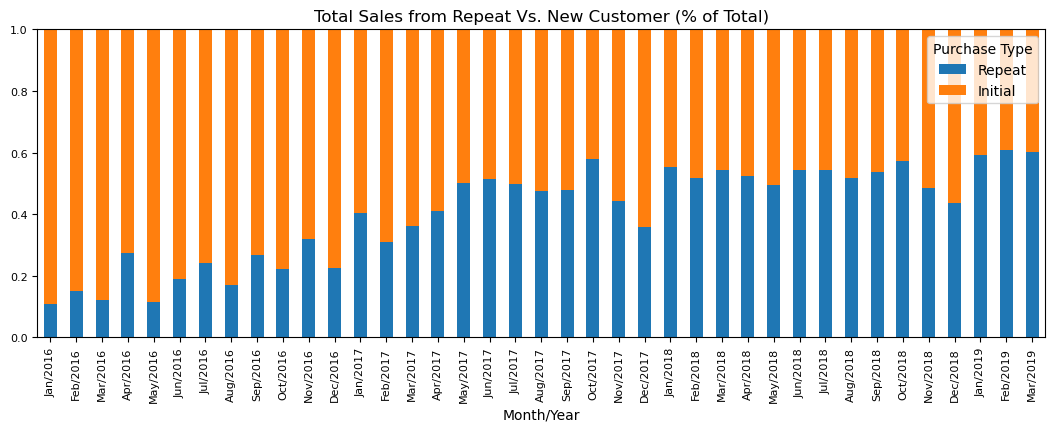

In [23]:
ax = initVrep.plot.bar(stacked=True,
                      figsize=(13,4),
                      title="Total Sales from Repeat Vs. New Customer (% of Total)",
                      xlabel='Month/Year',
                      fontsize=8)

ax.set_xticklabels([f'{pd.Timestamp(year=y, month=m, day=1):%b/%Y}' for y, m in initVrep.index], 
                   rotation=90, 
                   ha='center')

ax.legend(['Repeat', 'Initial'], title='Purchase Type')
ax.set_ylim((0,1))
plt.show()

In [24]:
# Free-up memory - Garbage collect
del initVrep, ax
gc.collect()

20167

#### 6. Initial versus Repeat AOV

- **What**: average spend per purchase on initial purchase vs all repeat purchases
- **Why**: we typically observe significant differences between initial and repeat spends
- **How**: group data by year & month periods and whether the purchase was an initial purchase or repeat purchase. Once grouped, compute the average net sales (average order value) for each type of customer over time. 

**Anaylsis**: Repeat purchases exhibit greater variation over time, whereas initial purchases have remained relatively stable. Since November 2017, AOV of initial purchases have been higher than AOV of repeat purchases.

In [25]:
initVrepAOV = df.groupby([df.index.year, df.index.month, df['initial_purch']])['net_sales'].mean()
initAOV = initVrepAOV.xs(1, level='initial_purch')
repAOV = initVrepAOV.xs(0, level='initial_purch')

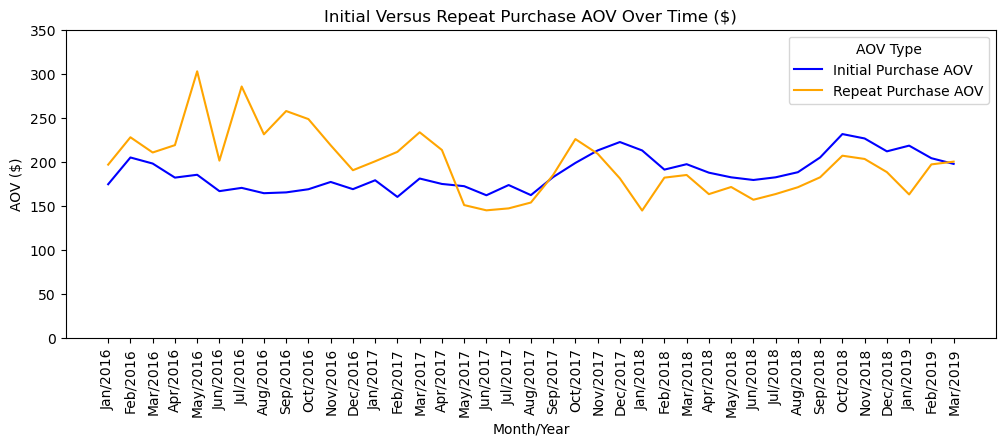

In [26]:
fig, ax = plt.subplots(figsize=(12, 4))

initAOV.plot(ax=ax, label='Initial Purchase AOV', color='blue')

repAOV.plot(ax=ax, label='Repeat Purchase AOV', color='orange')

ax.set_title("Initial Versus Repeat Purchase AOV Over Time ($)")
ax.set_xlabel("Month/Year")
ax.set_ylabel("AOV ($)")
ax.set_xticks(range(len(initAOV.index)))
ax.set_xticklabels([f'{pd.Timestamp(year=y, month=m, day=1):%b/%Y}' for y, m in initAOV.index], 
                   rotation=90, 
                   ha='center')
ax.legend(title='AOV Type')
ax.set_ylim(0,350)

plt.show()

In [27]:
# Free-up memory - Garbage collect
del repAOV, initAOV, initVrepAOV, ax, fig
gc.collect()

6370

#### 7. Sales and AOV by Source

- **What**: total sales and AOV by source of order (e.g., online versus in-store)
- **Why**: profitability and unit economics may differ significantly by channel
- **How**: net sales are grouped by different channels across years and months. 

**Analysis**: between online and physical store, online sales contributes the most to total sales. Average order value on web is relatively stable while average order value in store is slightly higher than web.

In [28]:
# Total sales by each source
sales_source = df.groupby([(df.index.year), (df.index.month), df['source']], observed=True)['net_sales'].sum()
sales_source = sales_source.unstack().fillna(0)

# Percentage contribution of each source to the total sales
sales_source_pct = sales_source.div(sales_source.sum(axis=1), axis=0) 

# AOV by each source
aov_source = df.groupby([(df.index.year), (df.index.month), df['source']], observed=True)['net_sales'].mean()
aov_source = aov_source.unstack().fillna(0)

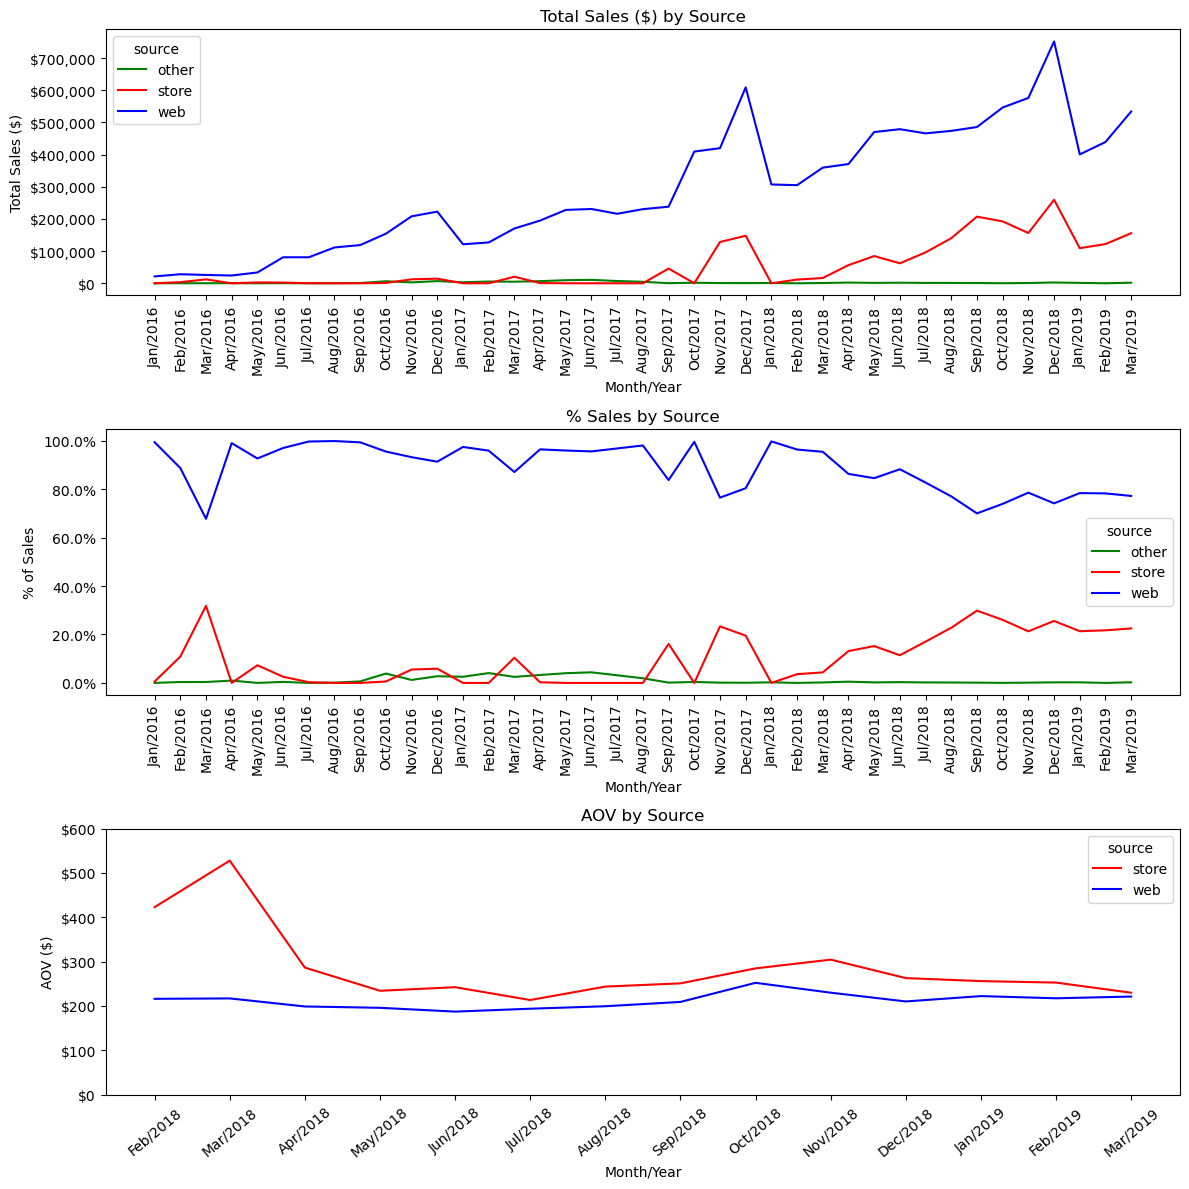

In [29]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

ax = axes[0]
sales_source.plot(ax=ax, label='$ Sales by Source', color=['green', 'red', 'blue'])
ax.set_title("Total Sales ($) by Source")
ax.set_xlabel("Month/Year")
ax.set_ylabel("Total Sales ($)")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${y:,.0f}'))
ax.set_xticks(range(len(sales_source.index)))
ax.set_xticklabels([f'{pd.Timestamp(year=y, month=m, day=1):%b/%Y}' for y, m in sales_source.index], 
                   rotation=90, 
                   ha='center')
ax.legend(title='source', loc='upper left')

ax = axes[1]
sales_source_pct.plot(ax=ax, label='% Sales by Source', color=['green', 'red', 'blue'])
ax.set_title("% Sales by Source")
ax.set_xlabel("Month/Year")
ax.set_ylabel("% of Sales")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.1%}'))
ax.set_xticks(range(len(sales_source.index)))
ax.set_xticklabels([f'{pd.Timestamp(year=y, month=m, day=1):%b/%Y}' for y, m in sales_source.index], 
                   rotation=90, 
                   ha='center')

ax=axes[2]
aov_source_sub = aov_source.loc[(aov_source.index >= (2018, 2))]
aov_source_sub.plot(y=['store', 'web'], ax=ax, color=['red', 'blue'])
ax.set_title("AOV by Source")
ax.set_xlabel("Month/Year")
ax.set_ylabel("AOV ($)")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${y:,.0f}'))
ax.set_xticks(range(len(aov_source_sub.index)))
ax.set_xticklabels([f'{pd.Timestamp(year=y, month=m, day=1):%b/%Y}' for y, m in aov_source_sub.index], 
                   rotation=40, 
                   ha='center')
ax.set_ylim((0,600))

fig.tight_layout()

In [30]:
# Free-up memory - Garbage collect
del sales_source, sales_source_pct, aov_source, aov_source_sub, axes, fig, ax
gc.collect()

16863

#### 8. First Purchase Profitability

- **What**: average variable profit from initial purchase, minus CAC
- **Why**: If profitable, everything else is “icing on the cake” 
  - Measure of how much CLV depends on repeat purchasing (risk)
- **How**: determine contribution margin to apply to all transactions, filter transaction log by initial purchase, group by year and month (period) and compute average of contribution profit for all periods. We use the average initial purchase contribution profit (and profit net of CAC) to compare with the CAC over time. 
  - We need transaction-level **contribution (margin) profitability**, what to include:
    - Direct labor and materials (COGS)
    - Handling of inventory
    - Fulfillment
    - Merchant processing fees
    - All return-related expenses (shipping, re-stocking)
    - [Indirect effectively variable expenses]

*In an ideal scenario, we would have the complete variable expense at a transaction level. However, this is often not the case.*

**Analysis**: Average initial contribution profit has remained stable over time given the single contribution margin assumption (40% in this case). As CAC has increased over time, average initial profit (contribution profit net of CAC) has decreased, but still remains positive, suggesting that (on average) marketing spend on customer acquisition is recovered on initial purchase.

In [31]:
# Contribution Margin 
cm = 0.40

# Compute and add contribution profit
df['contribution_profit'] = df['net_sales'] * cm

# Filter dataframe for initial purchase and compute average contribution profit per period
initial_purchase = df[df['initial_purch'] == 1]
avg_cp = initial_purchase.groupby([initial_purchase.index.year, initial_purchase.index.month])['contribution_profit'].mean()

# Compute average initial purchase profitability
avg_profit = avg_cp - cac

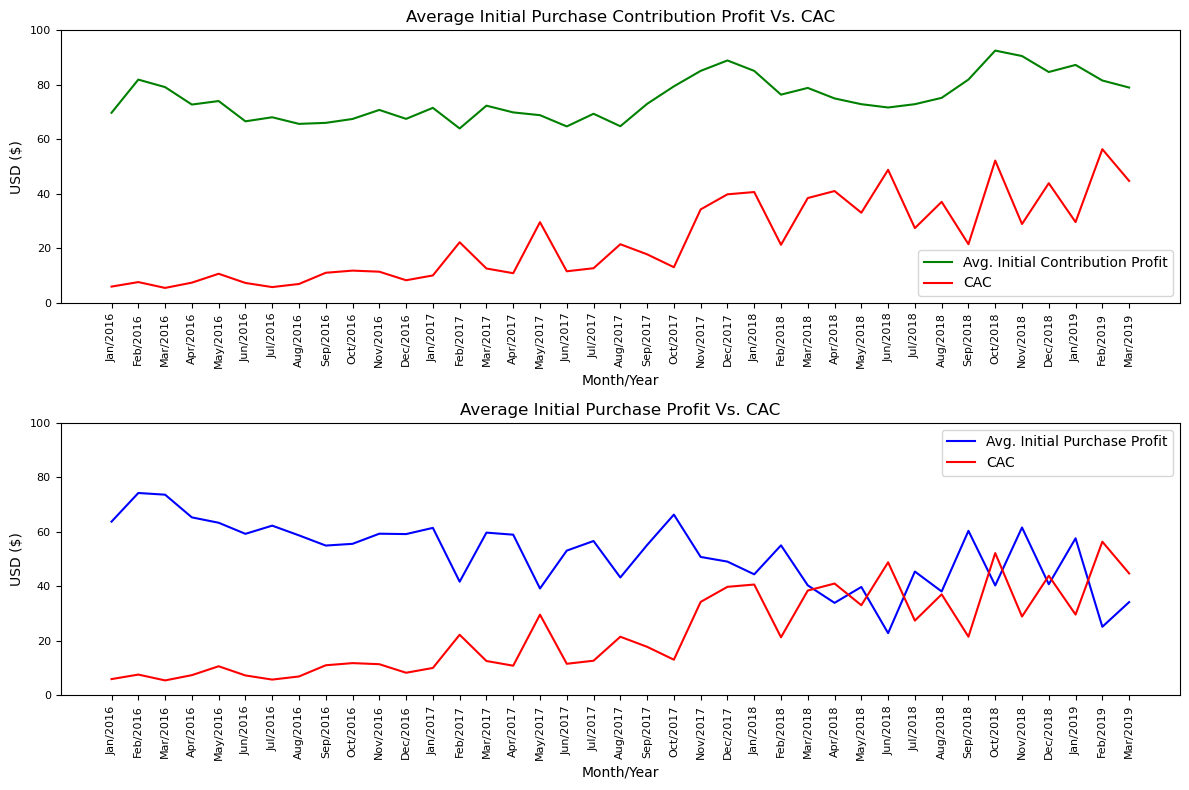

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(12,8))

ax = axes[0]
avg_cp.plot(ax=ax, color='green', fontsize=8, title="Average Initial Purchase Contribution Profit Vs. CAC")
cac.plot(ax=ax, color='red', fontsize=8)
ax.set_ylabel('USD ($)')
ax.set_xticks(range(len(cac.index)))
ax.set_xticklabels([f'{pd.Timestamp(year=y, month=m, day=1):%b/%Y}' for y, m in cac.index], 
                    rotation=90, 
                    ha='center')
ax.set_xlabel('Month/Year')
ax.set_ylim(0, 100)
ax.legend(['Avg. Initial Contribution Profit', 'CAC'])

ax = axes[1]
avg_profit.plot(ax=ax, color='blue', fontsize=8, title="Average Initial Purchase Profit Vs. CAC")
cac.plot(ax=ax, color='red', fontsize=8)
ax.set_ylabel('USD ($)')
ax.set_xticks(range(len(cac.index)))
ax.set_xticklabels([f'{pd.Timestamp(year=y, month=m, day=1):%b/%Y}' for y, m in cac.index], 
                    rotation=90, 
                    ha='center')
ax.set_xlabel('Month/Year')
ax.set_ylim(0, 100)
ax.legend(['Avg. Initial Purchase Profit', 'CAC'])

fig.tight_layout() 

In [33]:
# Free-up memory - Garbage collect
del avg_profit, avg_cp, axes, fig, cac
gc.collect()

124

#### 9. Cohorted Revenue (the “C3”)

- **What**: total revenues, broken down by acquisition cohort, over time
- **Why**: (exceedingly rich) one-chart summary of growth, acquisition, and retention
- **How**: choose an appropriate level of frequency (quarterly in this instance) for grouping cohorts and assessing sales over time, choose a level that avoids clutter. We start with creating a new column for "birthday" or acquisition date for all customers in the transactions dataframe, grouping the order date and acquisition date by quarters and summing the grouped net sales. Through this, we obtain a cross-tabular data of birthdays by columns and order dates by the row. The data shows the sales performance of each of the cohort from the date of the acquisition. Generate a stacked area chart for visual representation.
  
**Analysis**: visual representation of the cohort chart shows that newly acquired customers contribute the highest portion to sales every period. After the initial purchase, sales from previously acquired cohort reduces. However, over time, as more customers are acquired in earlier periods, their transactions in aggregate contribute to higher portion of sales. The repeat purchase of previously acquired customers acts as a base/foundation for total sales in that period. 

In [34]:
# Add 'birthday' column to transaction log as date of customer acquisition across all transactions
initial_purchase = initial_purchase.reset_index().set_index('cust_id')['order_date']
df['birthday'] = df['cust_id'].map(initial_purchase)

# Calculate sum of net sales and present a cross-tabular dataset, grouped by transaction date and birthday.
# Dates on both axis converted to quarters
cohort = df.groupby([df.index.to_period('Q'), df['birthday'].dt.to_period('Q')])['net_sales'].sum()
cohort = cohort.unstack()
cohort

birthday,2016Q1,2016Q2,2016Q3,2016Q4,2017Q1,2017Q2,2017Q3,2017Q4,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1
order_date,,,,,,,,,,,,,
2016Q1,91150.722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016Q2,15735.811,128141.312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016Q3,11181.131,34875.373,265916.911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016Q4,19506.162,23338.224,61185.982,524040.192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017Q1,9278.386,14089.400,29077.997,68122.275,331464.822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017Q2,11493.482,17048.967,39519.597,65624.689,81457.194,465761.556,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017Q3,7929.636,16451.474,34250.281,54746.133,51252.578,83127.330,494106.860,NaN,NaN,NaN,NaN,NaN,NaN
2017Q4,19973.083,24671.361,49586.693,103926.537,70408.221,98304.180,147478.929,1202622.941,NaN,NaN,NaN,NaN,NaN
2018Q1,7336.641,9563.281,23702.666,36546.601,42145.116,43817.566,62672.324,148597.943,626218.905,NaN,NaN,NaN,NaN


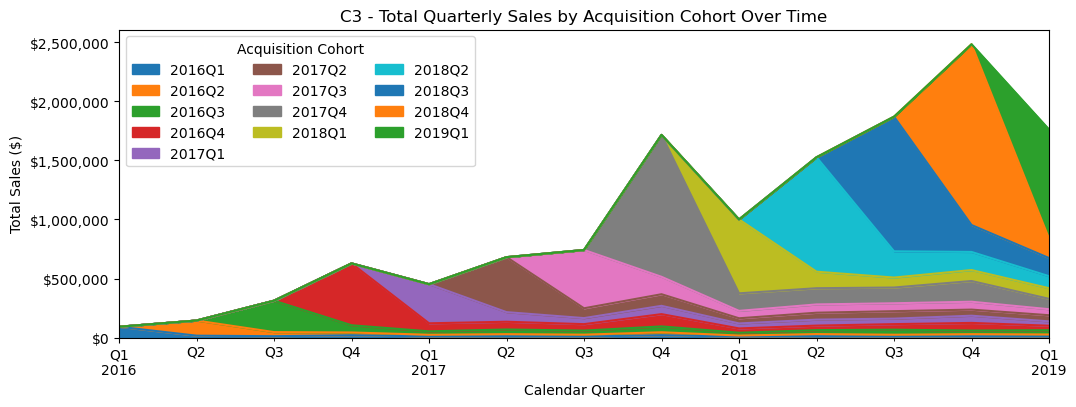

In [35]:
ax = cohort.plot.area(stacked=True, 
                      figsize=(12,4),
                      title="C3 - Total Quarterly Sales by Acquisition Cohort Over Time")

ax.set_xlabel('Calendar Quarter')
ax.set_ylabel('Total Sales ($)')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${y:,.0f}'))
ax.legend(title='Acquisition Cohort', loc="upper left", ncol=3)

In [36]:
# Free-up memory - Garbage collect
del initial_purchase, ax, cohort
gc.collect()

13200

#### 10. Cohorted Revenue Retention Curve

- **What**: average monthly revenue over customer lifetime as a % of initial revenue
- **Why**: measure of how well a firm is developing customers over time. Analyzing revenue retention by cohort can uncover valuable patterns that inform business strategies and customer relationship management.
- **How**: calculate months since acquisition, group transactions dataframe by birthday and months since acquisition (cohort) and compute the aggregate net sales for each cohort over time (*spend by customer tenure*). We then convert the aggregate cohort sales data as a percentage of the initial cohort revenue (*spend by tenure as a % of initial spend*). Visualizing the line chart helps analyze revenue retention as a function of months since acquisition.

**Analysis**: Revenue generated by monthly cohorts of customers reduces dramatically relative to initial purchase for all cohorts. Cohort revenue retention is low immediately following the acquisition period and then gradually plateaus with repeat purchases.

In [37]:
# Months since acquisition
df['months_acq'] = np.ceil(((df.index - df['birthday']).dt.days / 30.3)).astype(int)

# Spend by customer tenure 
spend_tenur = df.groupby([df['birthday'].dt.year, df['birthday'].dt.month, df['months_acq']])['net_sales'].sum().unstack()

# Spend by tenure as a % of initial spend
spend_tenur_pct = spend_tenur.div(spend_tenur[0], axis=0)

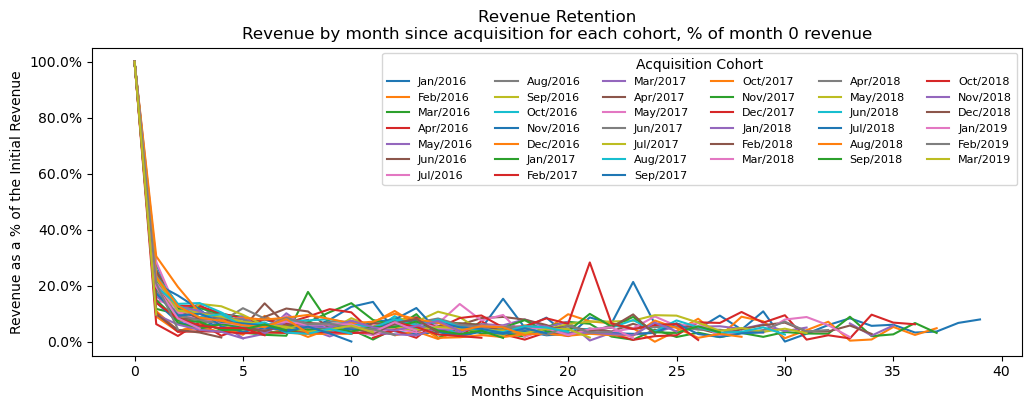

In [38]:
ax = spend_tenur_pct.T.plot(figsize=(12,4),
                   title="Revenue Retention\nRevenue by month since acquisition for each cohort, % of month 0 revenue")

ax.set_xlabel('Months Since Acquisition')
ax.set_ylabel('Revenue as a % of the Initial Revenue')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.1%}'))
ax.legend(title='Acquisition Cohort', loc="upper right", ncol=6, fontsize=8,
          labels=[f'{pd.Timestamp(year=y, month=m, day=1):%b/%Y}' for y, m in spend_tenur_pct.index])

In [39]:
# Free-up memory - Garbage collect
del spend_tenur_pct, ax
gc.collect()

3379

#### 11. Cohorted Cumulative Spend per Customer

- **How**: Compute the monthly cumulative spend for each cohort and divide the cumulative figures by the number of customers acquired in the cohort. (Use spend by customer tenure and monthly customers acquired to compute the cumulative spend per customer)

In [40]:
# Cumulative spend across each cohort per customer
cum_spend = spend_tenur.cumsum(axis=1).div(acquired, axis=0)

(0.0, 700.0)

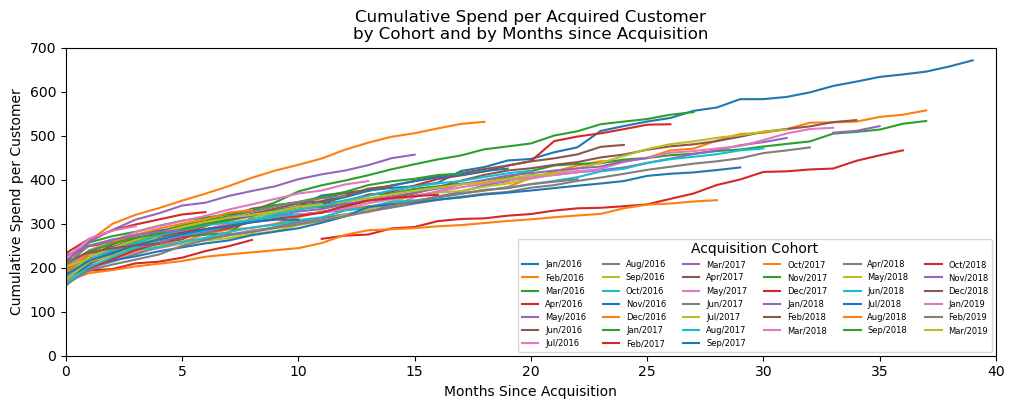

In [41]:
%matplotlib inline
ax = cum_spend.T.plot(figsize=(12,4),
                   title="Cumulative Spend per Acquired Customer\nby Cohort and by Months since Acquisition")
ax.set_xlabel('Months Since Acquisition')
ax.set_ylabel('Cumulative Spend per Customer')
ax.legend(title='Acquisition Cohort', loc="lower right", ncol=6, fontsize=6,
          labels=[f'{pd.Timestamp(year=y, month=m, day=1):%b/%Y}' for y, m in spend_tenur.index])
ax.set_xlim(0, 40)
ax.set_ylim(0, 700)

In [42]:
# Free-up memory - Garbage collect
del cum_spend, spend_tenur, acquired, ax
gc.collect()

12927

#### 12. Customer Spend Distribution

- **What**: for a given cohort, distribution of total spend by customer
  - Proxy for the E(PAV) distribution
- **Why**: measure of how much revenue is coming from best vs everyone else 
- **How**: group transactions data by birthday (quarterly period) and customer ID. Sum the net sales for the grouped data to produce total spends by customer. 

**Analysis**: 

In [43]:
spend_dist = df.groupby([df['birthday'].dt.to_period('Q'), df['cust_id']])['net_sales'].sum()
spend_dist = spend_dist.unstack().T

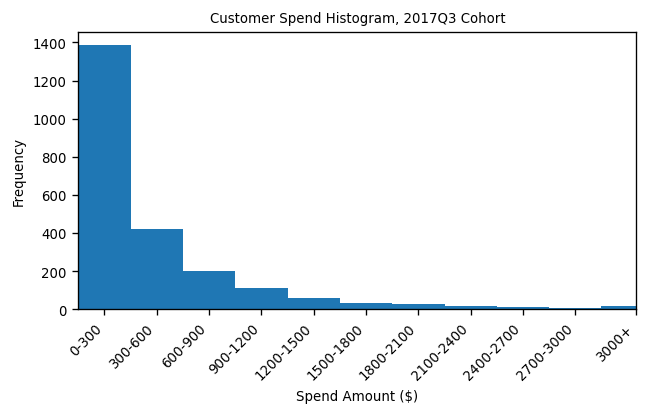

In [44]:
select = '2017Q3'

data = spend_dist[select].dropna()
bins = np.histogram_bin_edges(data, bins=10, range=(0, 3000))
bins = np.append(bins, np.max(data))
counts, bins = np.histogram(data, bins=bins)

plt.figure(figsize=(6, 3), dpi=120)
plt.stairs(counts, bins, fill=True)
plt.xlim(0,3200)
bin_midpoints = 0.5 * (bins[1:] + bins[:-1])
bin_labels = [f"{int(bins[i])}-{int(bins[i+1])}" if bins[i+1] < np.max(data) else f"{int(bins[i])}+" for i in range(len(bins) - 1)]
plt.xticks(list(bin_midpoints[:-1]) + [3200], bin_labels[:-1] + ["3000+"], rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)

plt.title(f"Customer Spend Histogram, {select} Cohort", fontsize=8)
plt.xlabel("Spend Amount ($)", fontsize=8)
plt.ylabel("Frequency", fontsize=8)
plt.show()

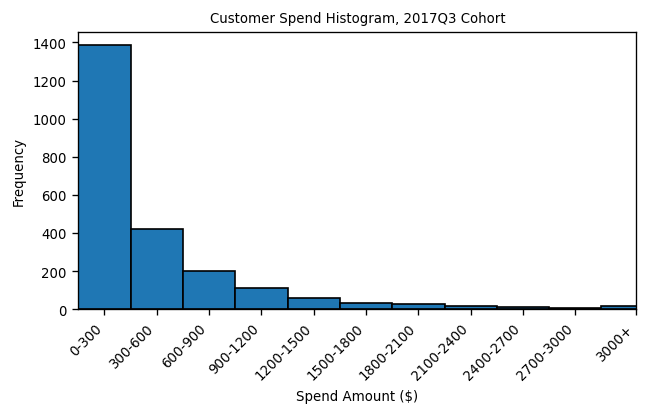

In [45]:
data = spend_dist[select].dropna()

bins = np.histogram_bin_edges(data, bins=10, range=(0, 3000))
bins = np.append(bins, np.max(data))

counts, bins = np.histogram(data, bins=bins)

plt.figure(figsize=(6, 3), dpi=120)
plt.hist(data, bins=bins, edgecolor="black")

plt.xlim(0, 3200)
bin_midpoints = 0.5 * (bins[1:] + bins[:-1])
bin_labels = [f"{int(bins[i])}-{int(bins[i+1])}" if bins[i+1] < np.max(data) else f"{int(bins[i])}+" for i in range(len(bins) - 1)]
plt.xticks(list(bin_midpoints[:-1]) + [3200], bin_labels[:-1] + ["3000+"], rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)

plt.title(f"Customer Spend Histogram, {select} Cohort", fontsize=8)
plt.xlabel("Spend Amount ($)", fontsize=8)
plt.ylabel("Frequency", fontsize=8)
plt.show()

#### 13. Pareto Curve for sales

- **What**: for a given cohort, get the % of revenues coming from the top x% of your customers
- **Why**: very important summary of customer sales concentration (similar to customer spend distribution)
- **How**: Use spend by customer data from spend distribution. Get the rank of each customer (break ties!). Get percentile of customer from rank, then round up to nearest 10th ( 99% -> 100%, 91% -> 100%, 89% -> 90%, ...). Get total spend within each resulting spending decile, convert to a cumulative sum, then express as a % of total revenue


**Analysis**: 

In [46]:
# Customer spend distribution
select = '2017Q1'
selected_spend = spend_dist[select].dropna()

# Customer spend distribution ranked - rank method='first' breaks tie when data is sorted
rank_percentile = selected_spend.sort_values(ascending=True).rank(method='first', ascending=False, pct=True)
# Round up rank_percentile to the nearest 10th
rank_percentile = np.ceil(rank_percentile * 10) / 10

# Group data by rank_percentile and calculate the sum of net sales for each percentile
spend_by_percentile = selected_spend.groupby(rank_percentile).sum()
spend_cumsum = spend_by_percentile.cumsum()
spend_cumsum_pct = spend_cumsum / spend_by_percentile.sum()
spend_cumsum_pct = pd.concat([pd.Series([0], index=[0]), spend_cumsum_pct])

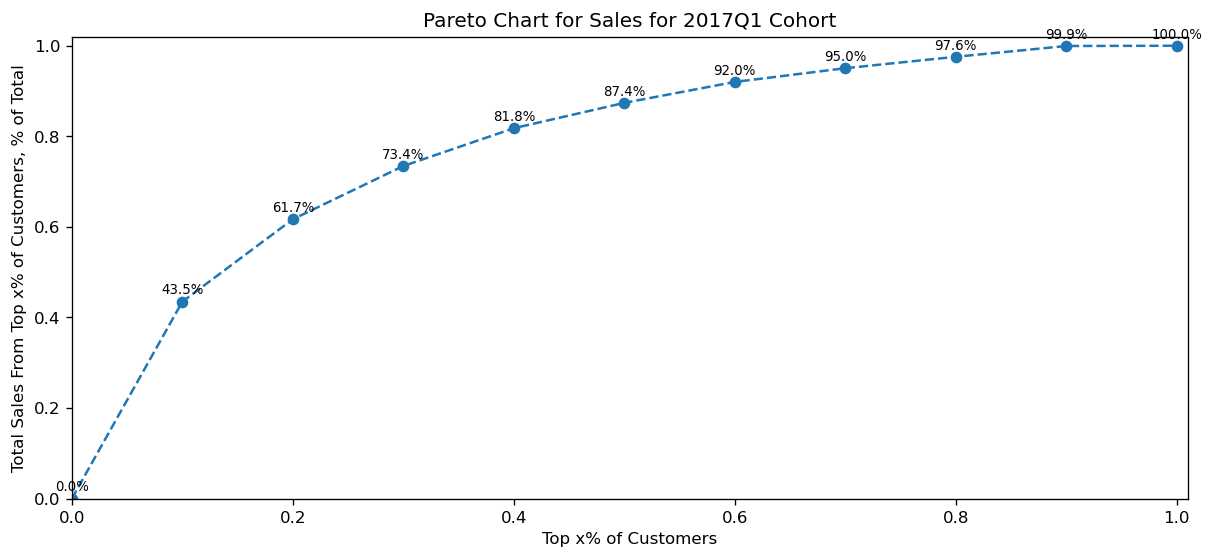

In [62]:
plt.figure(figsize=(12, 5), dpi=120)
plt.plot(spend_cumsum_pct, '--o')
for i, value in enumerate(spend_cumsum_pct):
    plt.text(spend_cumsum_pct.index[i], value+0.01, f'{value:.1%}', 
             ha='center', va='bottom', fontsize=8)
plt.title(f'Pareto Chart for Sales for {select} Cohort')
plt.xlabel('Top x% of Customers')
plt.ylabel('Total Sales From Top x% of Customers, % of Total')
plt.xlim(0,1.01)
plt.ylim(0,1.02)
plt.show()